In [148]:
import os
import torch
import random
import numpy as np
from torchmetrics.segmentation import DiceScore
from torchmetrics.classification import BinaryJaccardIndex
import matplotlib.pyplot as plt
import sys
import os
import cv2
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from model import MyUNet
from utils import get_all_test_pairs_path
from transform_manager import TransformManager

In [149]:
model_path = '../Models/fulltrain/model_19e0663ea2.pth'

In [150]:
DATASET_DIR = "../TestDataset/"

pairs_path = get_all_test_pairs_path(DATASET_DIR)

print(f"Successfully loaded {len(pairs_path)} pairs of images and masks.")

Successfully loaded 1133 pairs of images and masks.


In [151]:
pair = random.choice(pairs_path)
print(f"Selected pair: {pair}")
image_path = pair[0]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask_path = pair[1]
print(f"Selected mask: {mask_path}")
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask = (mask > 127).astype(np.uint8)

print(f"Mask shape: {mask.shape}")
assert image.shape[:2] == mask.shape, "Image and mask must have the same dimensions."

Selected pair: ['../TestDataset/Images\\7.png' '../TestDataset/Masks\\7.png']
Selected mask: ../TestDataset/Masks\7.png
Mask shape: (1080, 1920)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
num_filters = [32, 64, 128, 256]
model = MyUNet(in_channels=3, out_channels=1, num_filters=num_filters, n_convs=2).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

transform_manager = TransformManager(num_encoders=len(num_filters), seed=42)
transform = transform_manager.get_eval_transform()

transformed = transform(image=image, mask=mask)
applied_transforms = transformed["applied_transforms"]

preprocessed_image = transformed["image"]
preprocessed_mask = transformed["mask"]
preprocessed_mask = preprocessed_mask.unsqueeze(0).float()

dice_metric = DiceScore(num_classes=2).to(device)
iou_metric = BinaryJaccardIndex(threshold=0.5).to(device)

with torch.no_grad():
    input_image, input_mask = preprocessed_image.unsqueeze(0).to(device), preprocessed_mask.unsqueeze(0).to(device)
    outputs = model(input_image)
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > 0.5).float()

    dice_metric(outputs, input_mask)
    iou_metric(outputs, input_mask)

    print(f"Dice Score: {dice_metric.compute().item()}")
    print(f"IoU Score: {iou_metric.compute().item()}")


Using device: cuda
Dice Score: 0.7586206793785095
IoU Score: 0.6111111044883728


In [ ]:
print(f"Applied transforms: {applied_transforms}")

def get_resized_shape(applied_transforms: list):
    for name, params in applied_transforms:
        if name == "ResizeWithAspectRatio":
            return params.get("resized_shape", None)
    return None

Applied transforms: [('ResizeWithAspectRatio', {'shape': (1080, 1920, 3), 'interpolation': 1, 'resized_shape': (256, 455)}), ('PadIfNeeded', {'shape': (256, 455, 3), 'fill': 0.0, 'fill_mask': 0.0, 'pad_top': 0, 'pad_bottom': 0, 'pad_left': 4, 'pad_right': 5}), ('Normalize', {'shape': (256, 464, 3)}), ('ToTensorV2', {'shape': (256, 464, 3)})]


Resized shape: (256, 455)
Input image shape: (256, 455, 3)
Input mask shape: (256, 455)
Output shape: (256, 455)


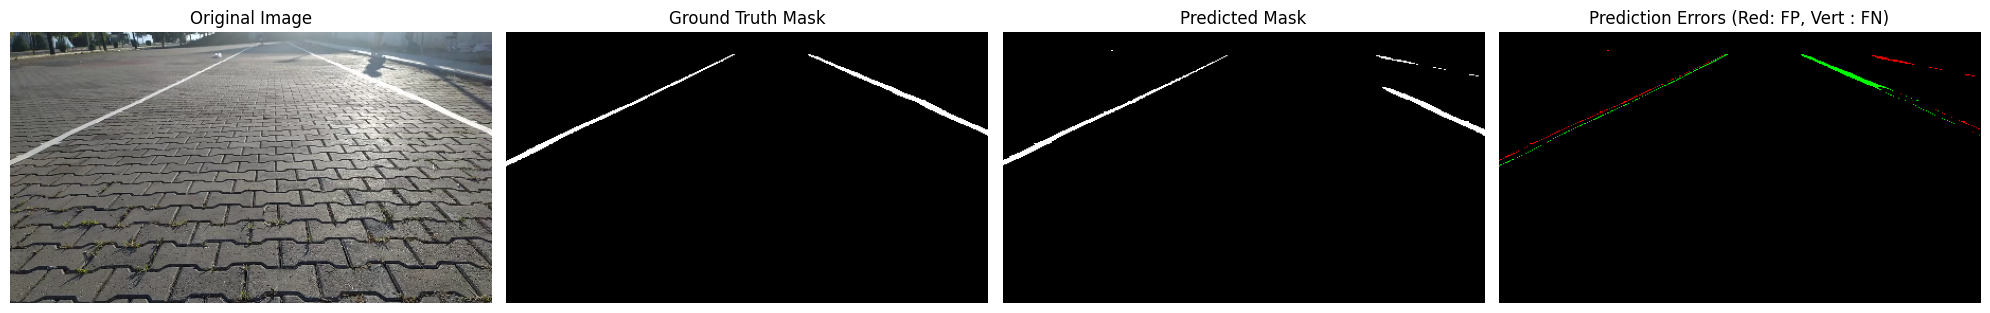

In [154]:
resized_shape = get_resized_shape(applied_transforms)
print(f"Resized shape: {resized_shape}")
input_image_np = TransformManager.reverse_image(preprocessed_image, resized_shape)
input_mask_np = TransformManager.reverse_mask(preprocessed_mask, resized_shape)
outputs_np = TransformManager.reverse_mask(outputs, resized_shape)

print(f"Input image shape: {input_image_np.shape}")
print(f"Input mask shape: {input_mask_np.shape}")
print(f"Output shape: {outputs_np.shape}")

fp = (outputs_np == 255) & (input_mask_np == 0)
fn = (outputs_np == 0) & (input_mask_np == 255)

diff_image = np.zeros((3, *input_image_np.shape[:2]), dtype=np.float32)

diff_image[0][fp] = 1.0  # Rouge pour Faux Positifs
diff_image[1][fn] = 1.0  # Vert pour Faux Négatifs

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Affichage de l'image originale
axes[0].imshow(input_image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Affichage du masque réel
axes[1].imshow(input_mask_np, cmap='gray')
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

# Affichage du masque prédit
axes[2].imshow(outputs_np, cmap='gray')
axes[2].set_title("Predicted Mask")
axes[2].axis('off')

axes[3].imshow(diff_image.transpose(1, 2, 0))  # Convertir en (H, W, C) pour l'affichage
axes[3].set_title("Prediction Errors (Red: FP, Vert : FN)")
axes[3].axis('off')

# Afficher l'ensemble
plt.tight_layout()
plt.show()